# This code sets uses an ampltiude threshold to detect song in a recording.

## It applies a bandpass filter, then sums the amplitudes across the filtered frequencies. Then, it saves a .json file with the file names and time segments of the detected song.

### This is the full amplitude filter for ONE .wav file recording.

Screen size ≈ 15.1 × 9.8 inches
Segment 1: 🎵 Song detected
Segment 2: 🎵 Song detected
Segment 3: 🎵 Song detected
Segment 4: ⚪ No song


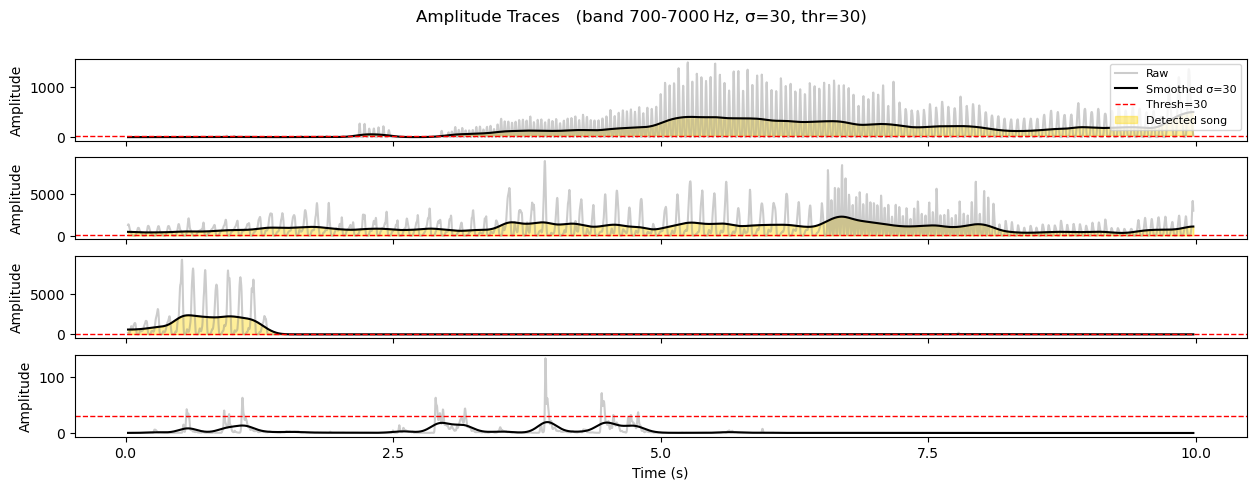

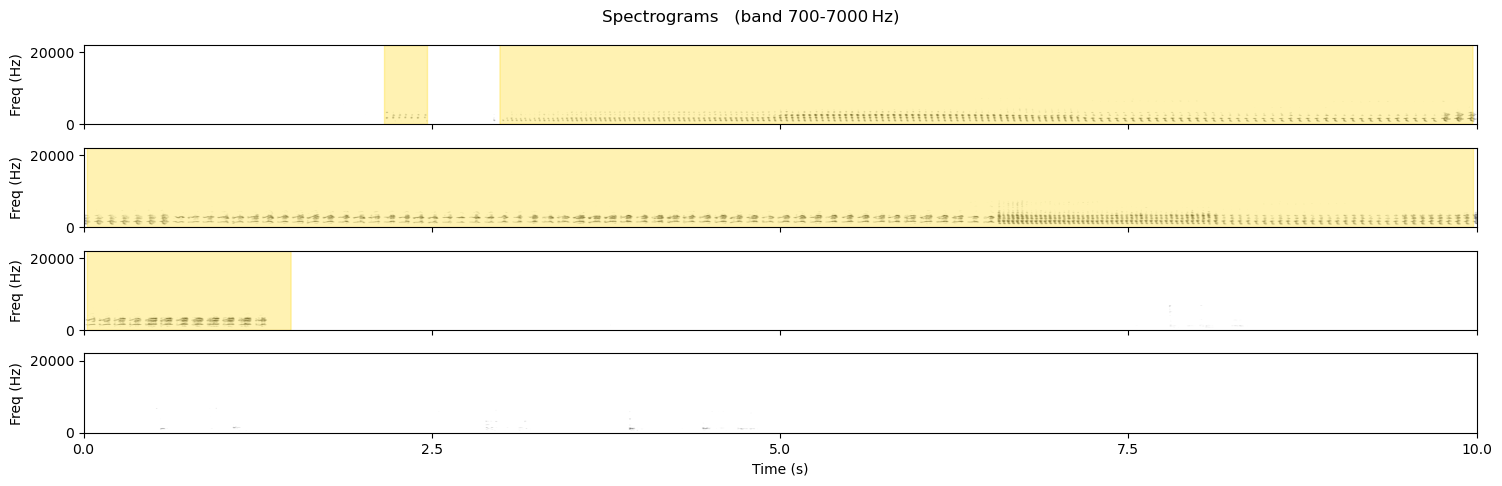

In [25]:
import numpy as np
from scipy.io import wavfile
from scipy.signal import spectrogram, windows, ellip, filtfilt
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt
import tkinter as tk

# ------------------------------------------------------------
# Utility ── get screen size in inches (approx.)
# ------------------------------------------------------------
def get_screen_resolution():
    root = tk.Tk()
    root.withdraw()
    screen_width = root.winfo_screenwidth()
    screen_height = root.winfo_screenheight()
    root.destroy()
    return screen_width / 100, screen_height / 100   # assume 100 dpi

width_inches, height_inches = get_screen_resolution()
print(f"Screen size ≈ {width_inches:.1f} × {height_inches:.1f} inches")

# ------------------------------------------------------------
# Main plotting routine
# ------------------------------------------------------------
def plot_spectrograms_by_segment(
        file_path: str,
        segment_duration: float = 10,
        bandpass_filter_low_cut: float = 500,
        bandpass_filter_high_cut: float = 8000,
        sigma: float = 100,
        threshold: float = 0.05
    ):
    """
    Visualise a WAV file in sequential segments.

    Parameters
    ----------
    file_path : str
        Path to the WAV file.
    segment_duration : float, default 10
        Length of each panel / chunk in seconds.
    bandpass_filter_low_cut : float
        Lower edge of the band‑pass filter (Hz).
    bandpass_filter_high_cut : float
        Upper edge of the band‑pass filter (Hz).
    sigma : float, default 100
        Gaussian‑smoothing σ (samples) applied to the amplitude trace.
    threshold : float, default 0.05
        Decision boundary on the smoothed amplitude trace; above = “song”.
    """
    try:
        # ---------- 1. Load audio ----------
        samplerate, data = wavfile.read(file_path)
        if data.ndim > 1:          # convert stereo → mono
            data = data.mean(axis=1)

        # ---------- 2. Band‑pass filter ----------
        nyquist = samplerate / 2
        wp = [bandpass_filter_low_cut / nyquist,
              bandpass_filter_high_cut / nyquist]
        b, a = ellip(5, 0.2, 40, wp, btype='band')
        data = filtfilt(b, a, data)    # zero‑phase

        # ---------- 3. Segment bookkeeping ----------
        segment_len = int(segment_duration * samplerate)
        num_segments = int(np.ceil(len(data) / segment_len))

        # ---------- 4. Prepare two figure stacks ----------
        fig1, axs_amp  = plt.subplots(num_segments, 1,
                                      figsize=(width_inches, height_inches * 0.5),
                                      sharex=True)
        fig2, axs_spec = plt.subplots(num_segments, 1,
                                      figsize=(width_inches, height_inches * 0.5),
                                      sharex=True)
        if num_segments == 1:      # make iterable even if single segment
            axs_amp  = [axs_amp]
            axs_spec = [axs_spec]

        # ---------- 5. Loop through segments ----------
        for i in range(num_segments):
            start = i * segment_len
            end   = start + segment_len
            seg = np.zeros(segment_len, dtype=data.dtype)
            seg[:max(0, min(segment_len, len(data) - start))] = data[start:end]

            # ----- Spectrogram -----
            f, t, Sxx = spectrogram(
                seg,
                fs=samplerate,
                window=windows.gaussian(2048, std=2048 / 8),
                nperseg=2048,
                noverlap=2048 - 119
            )
            Sxx_log = 10 * np.log10(Sxx + np.finfo(float).eps)
            Sxx_log = np.clip(Sxx_log, -2, None)      # floor a little
            Sxx_norm = (Sxx_log - Sxx_log.min()) / (Sxx_log.max() - Sxx_log.min())

            # ----- Amplitude trace -----
            band_rows = (f >= bandpass_filter_low_cut) & (f <= bandpass_filter_high_cut)
            amp_trace = np.sum(Sxx[band_rows, :], axis=0)
            smooth_trace = gaussian_filter1d(amp_trace, sigma=sigma)
            is_song = smooth_trace > threshold

            # ----- Plot panel 1: traces -----
            ax1 = axs_amp[i]
            ax1.plot(t, amp_trace,   color='gray',  alpha=0.4, label='Raw')
            ax1.plot(t, smooth_trace, color='black',          label=f'Smoothed σ={sigma}')
            ax1.axhline(threshold, color='red', linestyle='--', linewidth=1,
                        label=f'Thresh={threshold}')
            ax1.fill_between(t, smooth_trace, threshold, where=is_song, color='gold',
                             alpha=0.4, label='Detected song' if i == 0 else None)
            ax1.set_ylabel('Amplitude')
            if i == 0:
                ax1.legend(fontsize=8, loc='upper right')
            if i == num_segments - 1:
                ax1.set_xlabel('Time (s)')
                ax1.set_xticks(np.linspace(0, segment_duration, 5))
            else:
                ax1.set_xticks([])

            # ----- Plot panel 2: spectrogram -----
            ax2 = axs_spec[i]
            ax2.imshow(Sxx_norm, aspect='auto', origin='lower',
                       extent=[0, segment_duration, f.min(), f.max()],
                       cmap='binary')
            ax2.fill_between(t, f.min(), f.max(), where=is_song,
                             color='gold', alpha=0.3)
            ax2.set_ylabel('Freq (Hz)')
            if i == num_segments - 1:
                ax2.set_xlabel('Time (s)')
                ax2.set_xticks(np.linspace(0, segment_duration, 5))
            else:
                ax2.set_xticks([])

            # ----- Console feedback -----
            status = "🎵 Song detected" if np.any(is_song) else "⚪ No song"
            print(f"Segment {i+1}: {status}")

        # ---------- 6. Titles & layout ----------
        bp_range = f"{bandpass_filter_low_cut}-{bandpass_filter_high_cut} Hz"
        fig1.suptitle(f'Amplitude Traces   (band {bp_range}, σ={sigma}, thr={threshold})',
                      fontsize=12)
        fig2.suptitle(f'Spectrograms   (band {bp_range})', fontsize=12)
        plt.tight_layout()
        plt.show()

    except ValueError as err:
        print(f"[ERROR] {file_path}: {err}")

# ------------------------------------------------------------
# Example call – swap in your own file and parameters
# ------------------------------------------------------------
plot_spectrograms_by_segment(
    file_path = '/Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/USA5510_unsegmented_songs/55/USA5510_45755.25619988_4_8_7_6_59.wav',
    segment_duration=10,     # seconds per panel
    bandpass_filter_low_cut=700,             # lower edge of band‑pass (Hz)
    bandpass_filter_high_cut=7000,           # upper edge (Hz)
    sigma=30,                # smoothing strength (samples)
    threshold=30            # detection threshold (same units as smoothed trace)
)

In [ ]:
import numpy as np
from scipy.io import wavfile
from scipy.signal import spectrogram, windows, ellip, filtfilt
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt
import tkinter as tk
from pathlib import Path

# ------------------------------------------------------------
# Utility ── get screen size in inches (≈100 dpi assumption)
# ------------------------------------------------------------
def get_screen_resolution():
    root = tk.Tk()
    root.withdraw()
    screen_width  = root.winfo_screenwidth()
    screen_height = root.winfo_screenheight()
    root.destroy()
    return screen_width / 100, screen_height / 100   # inches

width_inches, height_inches = get_screen_resolution()
print(f"Screen size ≈ {width_inches:.1f} × {height_inches:.1f} inches")

# ------------------------------------------------------------
# Main visualisation routine
# ------------------------------------------------------------
def plot_spectrograms_by_segment(
        file_path: str,
        segment_duration: float = 10,
        bandpass_filter_low_cut: float = 500,
        bandpass_filter_high_cut: float = 8000,
        sigma: float = 100,
        threshold: float = 0.05
    ):
    """
    Plot stacked amplitude traces and spectrograms for a WAV file, forcing all
    amplitude panels to share identical y‑axis limits.

    Parameters
    ----------
    file_path : str
        Path to the WAV file.
    segment_duration : float, default 10
        Seconds per panel (six panels = 1 min total).
    bandpass_filter_low_cut : float
        Lower edge of band‑pass filter (Hz).
    bandpass_filter_high_cut : float
        Upper edge of band‑pass filter (Hz).
    sigma : float, default 100
        σ (samples) for Gaussian smoothing of the amplitude trace.
    threshold : float, default 0.05
        Decision boundary applied to the smoothed trace.
    """
    try:
        # ---------- 1. Load audio ----------
        samplerate, data = wavfile.read(file_path)
        if data.ndim > 1:                      # stereo → mono
            data = data.mean(axis=1)

        # ---------- 2. Band‑pass filter ----------
        nyquist = samplerate / 2
        wp      = [bandpass_filter_low_cut / nyquist,
                   bandpass_filter_high_cut / nyquist]
        b, a    = ellip(5, 0.2, 40, wp, btype='band')
        data    = filtfilt(b, a, data)

        # ---------- 3. Segment bookkeeping ----------
        segment_len  = int(segment_duration * samplerate)
        num_segments = int(np.ceil(len(data) / segment_len))

        # ---------- 4. Prepare figure stacks ----------
        fig1, axs_amp  = plt.subplots(num_segments, 1,
                                      figsize=(width_inches,
                                               height_inches * 0.5),
                                      sharex=True)
        fig2, axs_spec = plt.subplots(num_segments, 1,
                                      figsize=(width_inches,
                                               height_inches * 0.5),
                                      sharex=True)
        if num_segments == 1:      # keep iterable
            axs_amp  = [axs_amp]
            axs_spec = [axs_spec]

        # ---------- 5. Loop through segments ----------
        global_amp_min, global_amp_max = np.inf, -np.inf

        for i in range(num_segments):
            start = i * segment_len
            end   = start + segment_len
            seg   = np.zeros(segment_len, dtype=data.dtype)
            seg[:max(0, min(segment_len, len(data) - start))] = data[start:end]

            # ----- Spectrogram -----
            f, t, Sxx = spectrogram(
                seg,
                fs=samplerate,
                window=windows.gaussian(2048, std=2048 / 8),
                nperseg=2048,
                noverlap=2048 - 119
            )
            Sxx_log  = 10 * np.log10(Sxx + np.finfo(float).eps)
            Sxx_log  = np.clip(Sxx_log, -2, None)
            Sxx_norm = ((Sxx_log - Sxx_log.min()) /
                        (Sxx_log.max() - Sxx_log.min()))

            # ----- Amplitude trace -----
            band_rows   = (f >= bandpass_filter_low_cut) & (f <= bandpass_filter_high_cut)
            amp_trace   = np.sum(Sxx[band_rows, :], axis=0)
            smooth_trace = gaussian_filter1d(amp_trace, sigma=sigma)
            is_song      = smooth_trace > threshold

            # Track global min/max for unified y‑axis
            global_amp_min = min(global_amp_min, smooth_trace.min())
            global_amp_max = max(global_amp_max, smooth_trace.max())

            # ----- Plot amplitude panel -----
            ax1 = axs_amp[i]
            ax1.plot(t, amp_trace,    color='gray',  alpha=0.4, label='Raw')
            ax1.plot(t, smooth_trace, color='black',           label=f'Smoothed σ={sigma}')
            ax1.axhline(threshold, color='red', linestyle='--', linewidth=1,
                        label=f'Thresh={threshold}')
            ax1.fill_between(t, smooth_trace, threshold, where=is_song,
                             color='gold', alpha=0.4,
                             label='Detected song' if i == 0 else None)
            ax1.set_ylabel('Amplitude')
            if i == 0:
                ax1.legend(fontsize=8, loc='upper right')
            if i == num_segments - 1:
                ax1.set_xlabel('Time (s)')
                ax1.set_xticks(np.linspace(0, segment_duration, 5))
            else:
                ax1.set_xticks([])

            # ----- Plot spectrogram panel -----
            ax2 = axs_spec[i]
            ax2.imshow(Sxx_norm, aspect='auto', origin='lower',
                       extent=[0, segment_duration, f.min(), f.max()],
                       cmap='binary')
            ax2.fill_between(t, f.min(), f.max(), where=is_song,
                             color='gold', alpha=0.3)
            ax2.set_ylabel('Freq (Hz)')
            if i == num_segments - 1:
                ax2.set_xlabel('Time (s)')
                ax2.set_xticks(np.linspace(0, segment_duration, 5))
            else:
                ax2.set_xticks([])

            # Console feedback
            status = "🎵 Song detected" if np.any(is_song) else "⚪ No song"
            print(f"Segment {i+1}: {status}")

        # ---------- 6. Apply common y‑limits ----------
        pad = 0.05 * (global_amp_max - global_amp_min or 1)
        common_ylim = (global_amp_min - pad, global_amp_max + pad)
        for ax in axs_amp:
            ax.set_ylim(common_ylim)

        # ---------- 7. Titles & layout ----------
        bp_range = f"{bandpass_filter_low_cut}-{bandpass_filter_high_cut} Hz"
        fig1.suptitle(f'Amplitude Traces   (band {bp_range}, σ={sigma}, thr={threshold})',
                      fontsize=12)
        fig2.suptitle(f'Spectrograms   (band {bp_range})', fontsize=12)
        plt.tight_layout()
        plt.show()

    except ValueError as err:
        print(f"[ERROR] {file_path}: {err}")

# ------------------------------------------------------------
# Example call – replace with your own WAV
# ------------------------------------------------------------
if __name__ == "__main__":
    example_wav = Path("/Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/USA5510_unsegmented_songs/55/USA5510_45755.25619988_4_8_7_6_59.wav")  # ⇦ change me!
    if example_wav.exists():
        plot_spectrograms_by_segment(
            file_path=str(example_wav),
            segment_duration=10,
            bandpass_filter_low_cut=700,
            bandpass_filter_high_cut=7000,
            sigma=30,
            threshold=30
        )
    else:
        print(f"Example WAV not found: {example_wav}")


# Amplitude only pipeline: Appy this to a folder of .wav files, then output a .json file with every .wav file name and the time segments of detected songs

## Change the folder_path in line 125 to the folder of .wav files you'd like to detect songs on.

In [ ]:
import os
import json
import numpy as np
from pathlib import Path
from scipy.io import wavfile
from scipy.signal import spectrogram, windows, ellip, filtfilt
from scipy.ndimage import gaussian_filter1d


# --------------------------------------------------------------------
# Core detector -------------------------------------------------------
# --------------------------------------------------------------------
def detect_song_intervals(
        data: np.ndarray,
        samplerate: int,
        bandpass_filter_low_cut: float = 500,
        bandpass_filter_high_cut: float = 8000,
        sigma: float = 100,
        threshold: float = 0.05,
        nperseg: int = 2048,
        noverlap: int = 1929         # 2048 - 119 (≈94 % overlap)
    ):
    """
    Return a list [[t_start, t_end], …] of song intervals in seconds
    for a single audio trace.
    """
    # --- Band‑pass filter (zero‑phase) ---
    nyquist = samplerate / 2
    wp = [bandpass_filter_low_cut / nyquist,
          bandpass_filter_high_cut / nyquist]
    b, a = ellip(5, 0.2, 40, wp, btype='band')
    data = filtfilt(b, a, data)

    # --- Spectrogram (gives us short‑time power) ---
    f, t, Sxx = spectrogram(
        data,
        fs=samplerate,
        window=windows.gaussian(nperseg, std=nperseg / 8),
        nperseg=nperseg,
        noverlap=noverlap,
        mode='psd'
    )

    # --- Broadband amplitude trace ---
    band_rows = (f >= bandpass_filter_low_cut) & (f <= bandpass_filter_high_cut)
    amp_trace = np.sum(Sxx[band_rows, :], axis=0)

    # --- Smooth + threshold ---
    smooth_trace = gaussian_filter1d(amp_trace, sigma=sigma)
    is_song = smooth_trace > threshold

    # --- Convert mask → contiguous [start, end] segments ---
    intervals = []
    if np.any(is_song):
        dt = t[1] - t[0]          # time step between centres of STFT hops
        in_segment = False
        for i, flag in enumerate(is_song):
            if flag and not in_segment:          # start of a new segment
                seg_start = t[i] - dt / 2
                in_segment = True
            if in_segment and (not flag or i == len(is_song) - 1):
                # end of segment (on first False, or at last True)
                seg_end = t[i] + dt / 2 if flag else t[i-1] + dt / 2
                intervals.append([float(seg_start), float(seg_end)])
                in_segment = False
    return intervals


# --------------------------------------------------------------------
# Batch runner --------------------------------------------------------
# --------------------------------------------------------------------
def run_detector_on_folder(
        folder_path: str,
        bandpass_filter_low_cut: float = 500,
        bandpass_filter_high_cut: float = 8000,
        sigma: float = 100,
        threshold: float = 0.05
    ):
    """
    Process every .wav file in `folder_path` and save a JSON with the
    detected intervals.
    """
    folder = Path(folder_path).expanduser().resolve()
    assert folder.is_dir(), f"{folder} is not a directory"

    wav_files = sorted(p for p in folder.glob("*.wav") if p.is_file())
    assert wav_files, f"No .wav files found in {folder}"

    result = {}
    print(f"🔍  Processing {len(wav_files)} wav files in: {folder}")

    for wav_path in wav_files:
        try:
            samplerate, data = wavfile.read(wav_path)
            if data.ndim > 1:                      # stereo → mono
                data = data.mean(axis=1)
            intervals = detect_song_intervals(
                data, samplerate,
                bandpass_filter_low_cut,
                bandpass_filter_high_cut,
                sigma,
                threshold
            )
            result[wav_path.name] = intervals
            status = "🎵" if intervals else "⚪"
            print(f"  {status} {wav_path.name:<40}  {len(intervals):2d} segments")

        except Exception as e:
            print(f"  ⚠️  Error processing {wav_path.name}: {e}")

    # ---- Save JSON --------------------------------------------------
    json_name = f"{folder.name}_amplitude_only_detected_song_intervals.json"
    json_path = folder.with_name(json_name)   # same parent directory
    with open(json_path, "w") as f:
        json.dump(result, f, indent=4)

    print(f"\n✅  Saved interval file → {json_path}")


# --------------------------------------------------------------------
# Example call --------------------------------------------------------
# --------------------------------------------------------------------
if __name__ == "__main__":
    run_detector_on_folder(
        folder_path="/Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/USA5510_unsegmented_songs/55",
        bandpass_filter_low_cut=700,
        bandpass_filter_high_cut=7000,
        sigma=30,
        threshold=500
    )

🔍  Processing 200 wav files in: /Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/USA5510_unsegmented_songs/55
  🎵 USA5510_45755.22382904_4_8_6_13_2.wav      1 segments
  🎵 USA5510_45755.23801765_4_8_6_36_41.wav     1 segments
  🎵 USA5510_45755.24425276_4_8_6_47_5.wav      1 segments
  🎵 USA5510_45755.25551217_4_8_7_5_51.wav      1 segments
  🎵 USA5510_45755.25568837_4_8_7_6_8.wav       1 segments
  🎵 USA5510_45755.25604998_4_8_7_6_44.wav      1 segments
  🎵 USA5510_45755.25619988_4_8_7_6_59.wav      1 segments
  🎵 USA5510_45755.25666577_4_8_7_7_46.wav      1 segments
  🎵 USA5510_45755.25701628_4_8_7_8_21.wav      1 segments
  🎵 USA5510_45755.25756457_4_8_7_9_16.wav      1 segments
  🎵 USA5510_45755.25771625_4_8_7_9_31.wav      1 segments
  🎵 USA5510_45755.25778467_4_8_7_9_38.wav      1 segments
  🎵 USA5510_45755.25804229_4_8_7_10_4.wav      1 segments
  🎵 USA5510_45755.25849428_4_8_7_10_49.wav     1 segments
  🎵 USA5510_45755.25887979_4_8_7_11_27.wav     1 se